In [16]:
import torch
import argparse
import random
import math
from torch.utils import data
from torchvision import datasets, transforms

from J_Model import PCModel
import J_optim as optim
import J_utils as utils

from PIL import Image
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
from copy import copy
from time import perf_counter
from scipy.stats import ttest_ind, bootstrap
import seaborn as sns
import pandas as pd

from stimuli_data import *
from image_net_data import *
from output_embedding import *

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
default_font_size = 18
plt.rcParams.update({'font.size': default_font_size})

In [19]:
output_vec_dic = load_vector()

In [20]:
# ====================================================================================
#
# Global Parameters and Settings
#
# ====================================================================================
parser = argparse.ArgumentParser(description='Predictive Coding')

# dataset params
parser.add_argument('--batch-size', type=int, default=64,
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000,
                    help='input batch size for testing (default: 1000)')

# optim params
parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
parser.add_argument('--epoch', type=int, default=10, help='epochs for training') #12

# inference params
parser.add_argument('--infer-lr', type=float, default=0.005, help='Inference learning rate')
parser.add_argument('--infer-iter', type=int, default=1000, help='Iteration for inference') #500
parser.add_argument('--test-iter', type=int, default=1000, help='Iteration for testing') #2000
parser.add_argument('--test-infer-iter', type=int, default=1000, help='Iteration for testing') #20000
parser.add_argument('--test-lr', type=int, default=0.005, help='Iteration for testing')

# convergence tolerance
parser.add_argument('--train-convergence-norm', type=str, default="Activity", help="Norm for measuring convergence")
parser.add_argument('--train-convergence-tolerance', type=float, default=1e-10, help="Tolerance for measuring convergence")
parser.add_argument('--test-convergence-norm', type=str, default="Activity", help="Norm for measuring convergence")
parser.add_argument('--test-convergence-tolerance', type=float, default=1, help="Tolerance for measuring convergence")
parser.add_argument('--output-vec-dic', type=float, default=output_vec_dic, help="Output vector embedding")

# experiment params
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
parser.add_argument('--test-every', type=int, default=1, help='Test Cycle regards to Epoch ')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')

# args = parser.parse_args()
args, unknown = parser.parse_known_args()

# Gpu Setting
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Misc. Setting
# torch.manual_seed(args.seed)
torch.manual_seed(random.randint(0,1024))


In [21]:
load_models = True
if load_models:
    population_size = 45
    networks = [PCModel(
        nodes=[2, 100, 200, 300, 6800], #[2, 100, 200, 300, 6800]
        mu_dt=args.infer_lr,
        act_fn=utils.Tanh()) for i in range(population_size)]
    for model_idx, model in enumerate(networks):
        for i in range(len(model.layers)):
            with open(f'Weights/model_{model_idx}_june_14_params_{i}.pickle', 'rb') as file:
                networks[model_idx].layers[i].weights = pickle.load(file)

In [22]:
model = networks[np.random.randint(0, len(networks))]

In [23]:
img = model.generate_image(label_batch=torch.tensor([[0.4, 1]]), 
                     n_iters=50000, 
                     fixed_preds=False, 
                     mu_dt=0.005, 
                     error_dt=None)

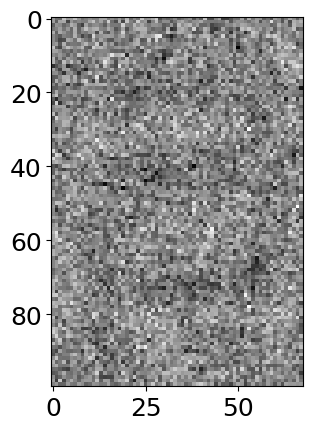

In [24]:
plt.figure()
plt.imshow(img.squeeze(0).reshape((100, 68)).cpu(), cmap="gray")
plt.show()